In [1]:
import os
import dill

import numpy as np
from matplotlib import pyplot as plt

import TwoPUtils
import STX3KO_analyses as stx




%load_ext autoreload
%autoreload 2

In [2]:
def update_sess_dict(mouse, f, KO = True):
    scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
    if KO:
        try:
            source_folder  =os.path.join('/media','mplitt','Backup Plus1','2P_Data')
            source_stem = os.path.join(source_folder,mouse,f['date'],f['scene'],scan_str)
            info = TwoPUtils.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')
        except:
            source_folder  = os.path.join('/media','mplitt','Backup Plus2','2P_Data')
            source_stem = os.path.join(source_folder,mouse,f['date'],f['scene'],scan_str)
            info = TwoPUtils.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')
    else:
        try:
            source_folder  =os.path.join('/media','mplitt','Backup Plus3')
            source_stem = os.path.join(source_folder,mouse,f['date'],f['scene'],scan_str)
            info = TwoPUtils.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')
        except:
            source_folder  = os.path.join('/media','mplitt','Backup Plus5','2P_Data')
            source_stem = os.path.join(source_folder,mouse,f['date'],f['scene'],scan_str)
            info = TwoPUtils.scanner_tools.sbx_utils.loadmat(source_stem+'.mat')

    f['mouse']=mouse
    f.update({'scan_file': source_stem + '.sbx',
              'scanheader_file': source_stem + '.mat',
              'vr_filename': os.path.join("/home/mplitt/VR_scratch",f['mouse'],f['date'],"%s_%d.sqlite" %(f['scene'],f['session'])),
              'scan_number': f['scan'],
              'prompt_for_keys': False,
              'VR_only': False,
              'scanner': "NLW",
             })
    return f

In [3]:
def run_all_sessions(sess_dict,KO=True):
    failed_sessions = []
    for mouse, file_list in sess_dict.items():
        for f in file_list:
            if isinstance(f, dict):
                f = update_sess_dict(mouse,f,KO=KO)
                scan_str = "%s_%03d_%03d" % (f['scene'],f['session'],f['scan'])
                if mouse in ['4467975.5', '4467333.1']:
                    f['s2p_path']=os.path.join("/home/mplitt/2P_scratch",f['mouse'],f['date'],f['scene'],scan_str,'suite2p')
                else:
                    f['s2p_path']=os.path.join("/mnt/BigDisk/2P_scratch",f['mouse'],f['date'],f['scene'],scan_str,'suite2p')

                try:
                    sess = stx.session.YMazeSession(**f)
                    sess.load_scan_info()
                    sess.align_VR_to_2P()
                    sess.load_suite2p_data(which_ts=('F', 'Fneu'))
                    sess.get_trial_info()
                    sess.neuropil_corrected_dff()
                    sess.place_cells_calc()
                    TwoPUtils.sess.save_session(sess,'/home/mplitt/YMazeSessPkls')
                except:
                    failed_sessions.append(f)

            elif isinstance(f, tuple) or isinstance(f, list):
                if mouse in ['4467975.5', '4467333.1']:
                    s2p_path=os.path.join("/home/mplitt/2P_scratch",mouse,f[0]['date'],'combined','suite2p')
                else:
                    print(f)
                    s2p_path=os.path.join("/mnt/BigDisk/2P_scratch",mouse,f[0]['date'],'combined','suite2p')

                
                ops = np.load(os.path.join(s2p_path,"plane0","ops.npy"),allow_pickle=True).all()
                comb_frames = 0
                for _f in f:

                    _f = update_sess_dict(mouse, _f,KO=KO)
                    if mouse in ['4467975.5', '4467333.1']:
                        _f['s2p_path']=os.path.join("/home/mplitt/2P_scratch",f[0]['mouse'],f[0]['date'],'combined','suite2p')
                    else:
                        _f['s2p_path']=os.path.join("/mnt/BigDisk/2P_scratch",f[0]['mouse'],f[0]['date'],'combined','suite2p')

                    try:
                        sess = stx.session.YMazeSession(**_f)
                        sess.load_scan_info()
                        sess.align_VR_to_2P()
                        print(slice(comb_frames,comb_frames+sess.scan_info['max_idx']))
                        sess.load_suite2p_data(which_ts=('F', 'Fneu'), frames = slice(comb_frames,comb_frames+sess.scan_info['max_idx']))

                        sess.get_trial_info()
                        sess.neuropil_corrected_dff()
                        sess.place_cells_calc()
                        TwoPUtils.sess.save_session(sess,'/home/mplitt/YMazeSessPkls')

                        comb_frames += sess.scan_info['max_idx']

                    except:
                        failed_sessions.append(_f)
                print("ops max idx %d, combined sbx max idx %d" % (ops['nframes'], comb_frames))



            else:
                failed_sessions.append(['wrong type',f])

    return failed_sessions

In [5]:

mouse = '4467975.1'
sess_list = []
f = stx.ymaze_sess_deets.KO_sessions[mouse][6]
print(f)
s2p_path=os.path.join("/mnt/BigDisk/2P_scratch",mouse,f[0]['date'],'combined','suite2p')


ops = np.load(os.path.join(s2p_path,"plane0","ops.npy"),allow_pickle=True).all()
comb_frames = 0
for _f in f:

    _f = update_sess_dict(mouse, _f,KO=True)
    print(_f)

    _f['s2p_path']=os.path.join("/mnt/BigDisk/2P_scratch",f[0]['mouse'],f[0]['date'],'combined','suite2p')


    sess = stx.session.YMazeSession(**_f)
    sess.load_scan_info()
    sess.align_VR_to_2P(run_ttl_check=True)
    print(slice(comb_frames,comb_frames+sess.scan_info['max_idx']))
    sess.load_suite2p_data(which_ts=('F', 'Fneu'), frames = slice(comb_frames,comb_frames+sess.scan_info['max_idx']))

    sess.get_trial_info()
    sess.neuropil_corrected_dff()
    sess.place_cells_calc()
    sess.add_pos_binned_trial_matrix('F_dff')
    # add normalized timeseries. 
    # divide dff by 99th percentile for that cell on that session
    sess.add_timeseries(F_dff_norm=sess.timeseries['F_dff']/np.nanpercentile(sess.timeseries['F_dff'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('F_dff_norm')
    sess.add_pos_binned_trial_matrix('spks')
    sess.add_timeseries(spks_norm = sess.timeseries['spks']/np.nanpercentile(sess.timeseries['spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('spks_norm')
    TwoPUtils.sess.save_session(sess,'/home/mplitt/YMazeSessPkls')
    sess_list.append(sess)
#         comb_frames += sess.scan_info['max_idx']


({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 7, 'mouse': '4467975.1', 'scan_file': '/media/mplitt/Backup Plus1/2P_Data/4467975.1/04_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx', 'scanheader_file': '/media/mplitt/Backup Plus1/2P_Data/4467975.1/04_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat', 'vr_filename': '/home/mplitt/VR_scratch/4467975.1/04_10_2020/YMaze_LNovel_1.sqlite', 'scan_number': 3, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 's2p_path': '/mnt/BigDisk/2P_scratch/4467975.1/04_10_2020/combined/suite2p'}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 10, 'novel': -1, 'ravel_ind': 8, 'mouse': '4467975.1', 'scan_file': '/media/mplitt/Backup Plus1/2P_Data/4467975.1/04_10_2020/YMaze_RewardReversal/YMaze_RewardReversal_002_010.sbx', 'scanheader_file': '/media/mplitt/Backup Plus1/2P_Data/4467975.1/04_10_2020/YMaze_RewardReversal/YMaze_RewardReversal_002_010.mat', 'vr_filename': 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


166 4944
5879 10759
perm 0
perm 0
{'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 10, 'novel': -1, 'ravel_ind': 8, 'mouse': '4467975.1', 'scan_file': '/media/mplitt/Backup Plus1/2P_Data/4467975.1/04_10_2020/YMaze_RewardReversal/YMaze_RewardReversal_002_010.sbx', 'scanheader_file': '/media/mplitt/Backup Plus1/2P_Data/4467975.1/04_10_2020/YMaze_RewardReversal/YMaze_RewardReversal_002_010.mat', 'vr_filename': '/home/mplitt/VR_scratch/4467975.1/04_10_2020/YMaze_RewardReversal_2.sqlite', 'scan_number': 10, 'prompt_for_keys': False, 'VR_only': False, 'scanner': 'NLW', 's2p_path': '/mnt/BigDisk/2P_scratch/4467975.1/04_10_2020/combined/suite2p'}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
num aberrant ttls 0.0
(65509,) (26725,)
1728.6130621526024 1728.4850934815565
slice(0, 26725, None)
167 4862
5801 10613
11552 16380
17316 26724
perm 0
perm 0


Index(['time', 'trialnum', 't', 'posx', 'posz', 'dz', 'lick', 'reward',
       'tstart', 'teleport', 'scanning', 'manrewards', 'LR', 'pos', 'speed',
       'lick rate'],
      dtype='object')
Int64Index([ 27,  69,  37,  81,  59,  75,  36,  71,  25,  25,  81,  14,  13,
             73,  23,  37, 939,  64,  67,  43,  58,  30,  29,  81,  16,  39,
             61,  78,  27,  49,  22,  29, 939,  68,  72,  47,  38,  40,  54,
             15,  28,  61,  24,  78,  57,  30,  80,  44,  40,  16, 936,  61,
             27,  68,  74,  11,  14,  84,  58,  41,  27,  77,  77,  64,  13,
             60,  71,  78,  33,  73,  28,  42,  45,  50,  27,  73,  81,  80,
             55,  22,  58,  39,  78,  11,  32,  90,  23,  35],
           dtype='int64')


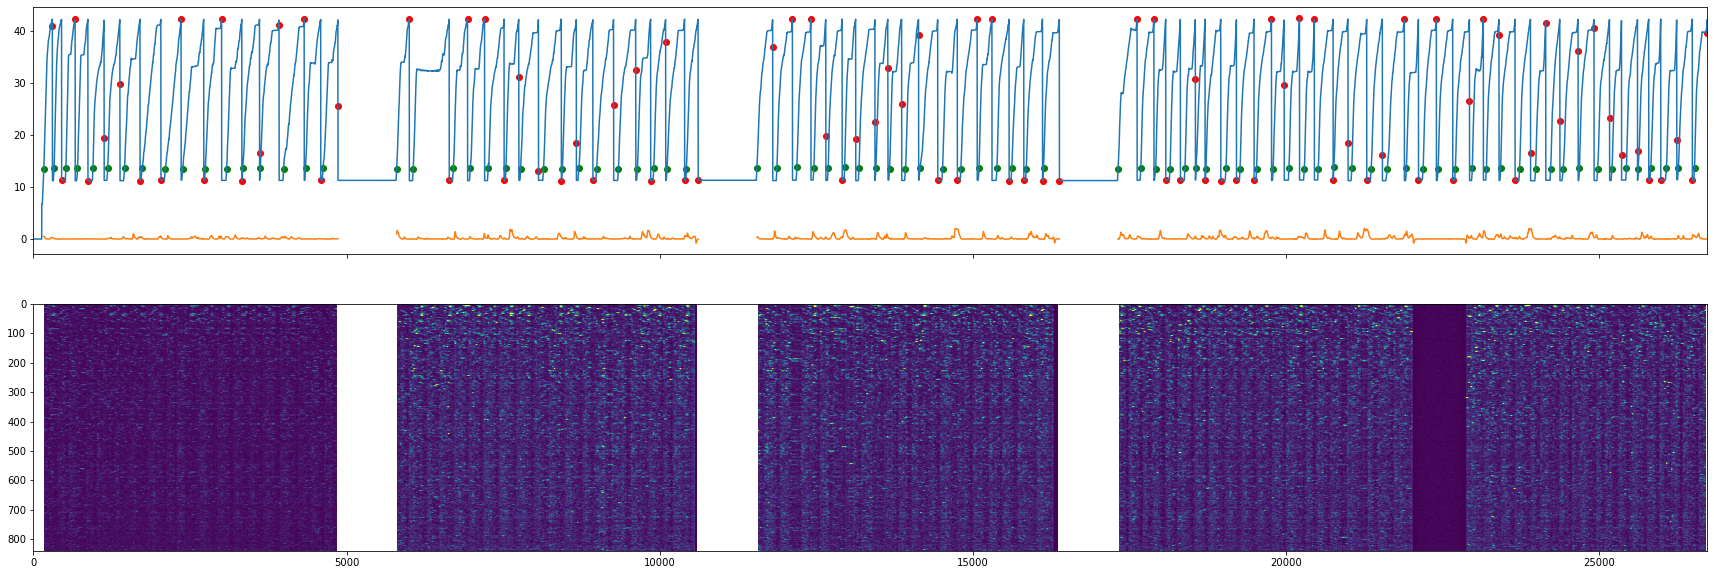

In [48]:
sess = sess_list[1]
print(sess.vr_data.columns)
fig,ax =  plt.subplots(2,1,figsize=[30,10], sharex=True)
ax[0].plot(sess.vr_data['t']._values)
ax[0].scatter(sess.trial_start_inds,sess.vr_data['t'].iloc[sess.trial_start_inds],color='green')
ax[0].scatter(sess.teleport_inds,sess.vr_data['t'].iloc[sess.teleport_inds],color='red')

print(sess.trial_start_inds[1:]-sess.teleport_inds[:-1])
ax[0].plot(sess.timeseries['F_dff'][2,:])

# fig, ax = plt.subplots(figsize = [30,5])
ax[1].imshow(sess.timeseries['F_dff'],aspect = 'auto',vmin=0,vmax=1)
# for (start,stop) in zip(sess.trial_start_inds,sess.teleport_inds):
#     print(start,stop,stop-start)
    
# sess.trial_start_inds
# sess.teleport_inds

In [4]:
def check_for_pickle(sess_dict):
    for mouse, file_list in sess_dict.items():
        for f in file_list:
            if isinstance(f,list) or isinstance(f,tuple):
                for _f in f:
                    if not os.path.exists(os.path.join("/home/mplitt/YMazeSessPkls",mouse,_f['date'],"%s_%d.pkl" % (_f['scene'],_f['session']))):
                        print('failed',_f)
            else:
                if not os.path.exists(os.path.join("/home/mplitt/YMazeSessPkls",mouse,f['date'],"%s_%d.pkl" % (f['scene'],f['session']))):
                    print('failed',_f)
                                                    
        

In [5]:
check_for_pickle(stx.ymaze_sess_deets.KO_sessions)

failed {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1}


In [28]:
check_for_pickle(stx.ymaze_sess_deets.CTRL_sessions)

In [6]:
KO_failed_sessions = run_all_sessions(stx.ymaze_sess_deets.KO_sessions)

({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1})


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
(10496,) (4245,)
274.5914603335018 274.49823143001515
slice(0, 4245, None)
227 3938


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:146: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:106: RuntimeWarning: Mean of empty slice
  P_map = P_map/np.nanmean(P_map, axis=0,keepdims=True)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:157: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
(75905,) (29954,)
1937.4089186457807 1937.3340070742802
slice(4245, 34199, None)
164 4456
5396 9745
10682 15385
16326 20668
21606 29952
perm 0
perm 0
ops max idx 34199, combined sbx max idx 34199


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
(98684,) (38344,)
2480.1160939868623 2479.991915108641


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
(92401,) (36648,)
2370.3731682668013 2370.2961091460334


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
(95536,) (37853,)
2448.3401970692266 2448.234461849419


FileNotFoundError: [Errno 2] No such file or directory: '/media/mplitt/Backup Plus2/2P_Data/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat'

In [15]:
CTRL_failed_sessions = run_all_sessions(stx.ymaze_sess_deets.CTRL_sessions,KO=False)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(97861,) (34310,)
2219.147296614452 2219.0763011622034
174 4674
5614 9802
10740 14950
15888 19974
20911 25580
26520 34308


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(85181,) (30330,)
1961.7962354724607 1961.6533602829713
168 3874
4808 8854
9790 13245
14180 17753
18688 22117
23051 30329


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(90977,) (31880,)
2062.023749368368 2061.906013137949
169 4795
5738 9798
10738 14812
15753 19354
20295 23985
24927 31879


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(87666,) (30523,)
1974.236862051541 1974.1364325416878
184 3925
4867 8958
9906 13654
14607 18744
19681 23000
23938 30513


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(99103,) (34327,)
2220.2891611925215 2220.175846387064
167 3719
4660 8678
9619 14061
14997 19849
20786 25064
26002 34326


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(95169,) (33797,)
2185.9758716523493 2185.8959070237497
168 4434
5371 9526
10463 14824
15763 19658
20599 24589
25528 33788


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(25010,) (9340,)
604.1639717028802 604.0384032339566
slice(0, 9340, None)


/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:215: UserWarning: Number of teleports and trial starts don't match
  warnings.warn("Number of teleports and trial starts don't match")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(61423,) (21431,)
1386.1687721071248 1386.0737746336536
slice(0, 21431, None)
189 4145
5082 8759
9697 13234
14168 21430


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
ops max idx 30771, combined sbx max idx 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(90476,) (32127,)
2077.9163719050025 2077.881758463871


/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:171: UserWarning: one frame correction
  warnings.warn('one frame correction')


171 4298
5233 9282
10216 13987
14924 19211
20146 24185
25120 32124


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(25751,) (9450,)
611.2909297625064 611.1531076301163
slice(0, 9450, None)
172 4530
5467 9449


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(59250,) (20759,)
1342.6901212733703 1342.6093986862052
slice(0, 20759, None)
171 3980
4915 8605
9539 13054
13990 20758


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
ops max idx 30209, combined sbx max idx 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(88542,) (30682,)
1984.5334765032844 1984.4204143506822
163 4117
5054 9186
10129 13755
14692 18298
19240 22709
23644 30680


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(82095,) (29270,)
1893.2323143001518 1893.0934815563417
172 3596
4531 7986
8923 12422
13358 16893
17830 21333
22270 29269


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(81729,) (28582,)
1848.6839312784234 1848.5942395149066
162 4208
5143 8766
9702 13069
14006 17229
18163 21593
22527 28580


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(9606,) (3633,)
235.00618999494694 234.91460333501772
slice(0, 3633, None)
163 3616


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(67654,) (23862,)
1543.4153612935827 1543.3087417887823
slice(0, 23862, None)
163 3167
4106 7480
8413 12188
13122 16729
17664 23860


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
ops max idx 27495, combined sbx max idx 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(99249,) (35167,)
2274.595755432036 2274.5063163213745
162 4658
5592 9951
10889 14885
15820 19817
20751 25070
26006 35166


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(76509,) (26724,)
1728.5203385548257 1728.4204143506822
160 3555
4489 7480
8414 11705
12639 15621
16555 19549
20482 26723


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(22131,) (7436,)
481.03082364830726 480.88933804952
slice(0, 7436, None)


/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:215: UserWarning: Number of teleports and trial starts don't match
  warnings.warn("Number of teleports and trial starts don't match")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(55906,) (20335,)
1315.266043456291 1315.1854471955535
slice(0, 20335, None)
167 3755
4689 8439
9373 12711
13644 20334


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
ops max idx 27771, combined sbx max idx 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(82848,) (29375,)
1900.0075795856492 1899.8847902981306
161 3472
4406 7620
8554 11968
12902 16414
17348 20967
21901 29374


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(21835,) (8395,)
543.0042950985346 542.9166245578575
slice(0, 8395, None)
168 3823
4758 8394


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(56993,) (20082,)
1298.9341839312783 1298.8216270843861
slice(0, 20082, None)
165 3575
4509 7988
8923 12572
13506 20065


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
ops max idx 28477, combined sbx max idx 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(98606,) (34154,)
2209.131884790298 2208.9863567458315
175 4192
5128 8947
9887 14440
15377 19821
20764 25481
26419 34153


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(108404,) (37689,)
2437.7573269327945 2437.627084386054
176 4723
5663 10347
11285 16018
16957 21819
22762 27395
28342 37687


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(102312,) (35533,)
2298.2886558868113 2298.178878221324
187 4636
5570 9804
10742 14792
15728 19850
20796 25431
26367 35523


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(104817,) (32240,)
2085.256568974229 2085.1905002526532


/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:171: UserWarning: one frame correction
  warnings.warn('one frame correction')


176 4407
5349 9163
10099 14043
14981 18563
19498 23514
24450 32237


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(87472,) (30325,)
1961.441258211218 1961.3299646286005
168 4299
5234 8914
9858 13549
14483 18236
19173 22722
23659 30324


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(82177,) (29019,)
1876.9399949469428 1876.859019706923
173 3248
4184 7653
8591 11896
12831 16381
17315 21012
21947 29017


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(28532,) (9371,)
606.1431278423446 606.0434562910561
slice(0, 9371, None)
165 4175
5113 9370


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(73021,) (26275,)
1699.4924204143506 1699.379484588176
slice(0, 26275, None)
170 4578
5512 10285
11221 16002
16938 26274


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
ops max idx 35646, combined sbx max idx 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(82767,) (29458,)
1905.3241536129358 1905.2531581606875
167 4200
5135 9084
10019 13711
14647 18030
18965 22424
23359 29456


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(23966,) (8931,)
577.6676351692773 577.5846387064174
slice(0, 8931, None)
166 4189
5125 8930


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(73705,) (25823,)
1670.2732440626578 1670.1445174330472
slice(0, 25823, None)
169 4287
5225 9837
10772 15531
16467 25822


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
ops max idx 34754, combined sbx max idx 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(36907,) (12725,)
823.1215260232441 822.9772612430521


/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:215: UserWarning: Number of teleports and trial starts don't match
  warnings.warn("Number of teleports and trial starts don't match")
/home/mplitt/repos/TwoPUtils/TwoPUtils/preprocessing.py:217: UserWarning: One more teleport and than trial start, Assuming the first trial start got clipped during 
  warnings.warn(("One more teleport and than trial start, Assuming the first trial start got clipped during "))


0 4338
5278 9187
10129 12721


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(61481,) (22651,)
1465.11066195048 1464.9823143001518
184 4092
5029 9134
10070 13530
14469 22650


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(27247,) (10164,)
657.4391106619505 657.33400707428
214 4949
5884 9555


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(65534,) (23026,)
1489.3173319858515 1489.2369883779688
213 4918
5862 9924
10866 14835
15771 23024


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(90720,) (31511,)
2038.146033350177 2038.0394138453767
180 4304
5240 9010
10048 13993
14928 18798
19734 23278
24217 31510


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(90206,) (31538,)
2039.911066195048 2039.7857503789794
190 4274
5211 9104
10056 13792
14726 18627
19563 23947
24883 31537


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(94829,) (33460,)
2164.212481051036 2164.0990399191514
191 4970
5915 10667
11603 15902
16841 20693
21641 25441
26486 33458


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(103701,) (35784,)
2314.523244062658 2314.413340070743
178 4805
5741 10456
11391 16002
16939 21486
22432 26768
27703 35783


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(27204,) (10151,)
656.5822385042951 656.4931783729156
slice(0, 10151, None)
169 4994
5933 10150


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(69171,) (24407,)
1578.6592976250631 1578.5588681152099
slice(0, 24407, None)
167 4869
5815 10148
11083 15135
16070 24406


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0
ops max idx 34558, combined sbx max idx 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(107537,) (37538,)
2427.963112683173 2427.8605356240528
197 4970
5905 10641
11577 16257
17196 21899
22833 27210
28144 37537


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(30947,) (10643,)
688.3880747852451 688.3153107630117
slice(0, 10643, None)
188 4870
5806 10641


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(73869,) (26609,)
1721.0698585144012 1720.9823143001518
slice(0, 26609, None)
174 4971
5911 10587
11524 16320
17257 26608


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


ops max idx 37252, combined sbx max idx 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(95956,) (33681,)
2178.4796614451743 2178.3931278423447
170 3869
4804 9044
9979 13936
14873 19197
20134 24140
25077 33680


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(84228,) (29796,)
1927.2147549267306 1927.1147043961598
169 3778
4715 7879
8814 12197
13137 17648
18589 22241
23178 29795


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(84419,) (29936,)
1936.2513895907025 1936.1697827185449
164 3849
4786 8475
9411 13004
13941 17149
18086 21280
22216 29934


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(87012,) (29451,)
1904.9437847397676 1904.8004042445682
164 3883
4819 8198
9135 13174
14111 17756
18694 21764
22702 29450


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(81112,) (28380,)
1835.6019454269833 1835.5290550783225
174 4241
5177 8674
9611 12809
13746 17162
18097 21263
22201 28378


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:256: UserWarning: Looking for coaligned suite2p sessions is not implemented yet
  warnings.warn("Looking for coaligned suite2p sessions is not implemented yet")


Fixing teleports
(84124,) (29194,)
1888.276907529055 1888.177867609904
171 3658
4595 8434
9369 13141
14079 17210
18144 21807
22743 29193


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:139: RuntimeWarning: Mean of empty slice
  SI = spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


perm 0


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:150: RuntimeWarning: Mean of empty slice
  _SI_perm =  spatial_info(np.nanmean(C_trial_mat,axis=0),occ)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/BigDisk/2P_scratch/4467333.1/06_12_2020/combined/suite2p/plane0/ops.npy'

In [ ]:
print(KO_failed_sessions)

NameError: name 'CTRL_failed_sessions' is not defined

In [5]:
def update_session(sess):
    sess.rm_timeseries('F_dFF')
    sess.neuropil_corrected_dff()
    sess.rm_pos_binned_trial_matrix('F_dff')
    sess.add_pos_binned_trial_matrix('F_dff')
    # add normalized timeseries. 
    # divide dff by 99th percentile for that cell on that session
    sess.add_timeseries(F_dff_norm=sess.timeseries['F_dff']/np.nanpercentile(sess.timeseries['F_dff'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('F_dff_norm')
    sess.add_pos_binned_trial_matrix('spks')
    sess.add_timeseries(spks_norm = sess.timeseries['spks']/np.nanpercentile(sess.timeseries['spks'],99,axis=1,keepdims=True))
    sess.add_pos_binned_trial_matrix('spks_norm')
#     sess.place_cells_calc(impute_nans=False,bin_size=1)
    TwoPUtils.sess.save_session(sess,'/home/mplitt/YMazeSessPkls')

In [8]:
for sess_dict in [stx.ymaze_sess_deets.KO_sessions_ravel, stx.ymaze_sess_deets.CTRL_sessions_ravel]:
    for mouse, sessions in sess_dict.items():
        print(mouse)
        for i, deets in enumerate(sessions):
            print(i)
            with open(os.path.join('/home/mplitt/YMazeSessPkls',mouse,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),'rb') as file:
                sess = dill.load(file)
            update_session(sess)



4467975.1
0
227 3938
1
164 4456
5396 9745
10682 15385
16326 20668
21606 29952
2
260 5104
6041 10792
11744 16594
17535 22195
23133 28008
28944 38342
3
193 4874
5811 10585
11525 16163
17099 21584
22519 27422
28362 36636
4
172 4877
5815 10445
11386 16106
17044 21907
22846 27555
28494 37841
5
192 4676
5613 9931
10868 15135
16072 20287
21227 25146
26083 34898
6
171 4733
5671 10336
11275 15933
16873 21527
22466 27346
28287 37648
7
166 4944
5879 10759
8
167 4862
5801 10613
11552 16380
17316 26724
9
186 4936
5871 10575
11514 16296
17238 22028
22966 27285
28225 36957
10
171 4871
5810 10524
11
168 5028
5969 10637
11577 16465
17406 26821
4467975.2
0
181 4249
5183 9010
9945 13818
14753 18464
19417 24005
24942 33471
1
184 4815
5905 10492
11427 16238
17246 22013
23065 27691
28631 38186
2
185 4816
5751 10444
11386 16064
17001 21970
22915 27763
28710 38179
3
164 5081
6027 10686
11628 16276
17242 22192
23134 27837
28791 38136
4
185 4967
5910 10599
11547 16265
17207 22194
23136 27948
28889 38404
5
185 4

In [7]:
mouse = '4467332.2'
for i, deets in enumerate(stx.ymaze_sess_deets.CTRL_sessions_ravel[mouse]):
    print(i)
    with open(os.path.join('/home/mplitt/YMazeSessPkls',mouse,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),'rb') as file:
        sess = dill.load(file)
    update_session(sess)

0
0 4338
5278 9187
10129 12721
1
184 4092
5029 9134
10070 13530
14469 22650
2
214 4949
5884 9555
3
213 4918
5862 9924
10866 14835
15771 23024
4
180 4304
5240 9010
10048 13993
14928 18798
19734 23278
24217 31510
5
190 4274
5211 9104
10056 13792
14726 18627
19563 23947
24883 31537
6
191 4970
5915 10667
11603 15902
16841 20693
21641 25441
26486 33458
7
178 4805
5741 10456
11391 16002
16939 21486
22432 26768
27703 35783
8
169 4994
5933 10150
9
167 4869
5815 10148
11083 15135
16070 24406
10
197 4970
5905 10641
11577 16257
17196 21899
22833 27210
28144 37537
11
188 4870
5806 10641
12
174 4971
5911 10587
11524 16320
17257 26608
